In [1]:
import pandas as pd 
import numpy as np 

data = pd.read_csv('Fraud_Data.csv')
data.head(5)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [4]:
# fix the ip address
# data['ip_address'] = round(data['ip_address'])

data['ip_address'] = data['ip_address'].astype(np.int64)

# besides the 'astype' method, we also have the 'map' or 'apply' some lambda function to convert the data type

data.head(5)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,732758369,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,350311388,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2621473820,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3840542444,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,415583117,0


In [8]:
pool_ip_address = pd.read_csv('IpAddress_to_Country.csv')

pool_ip_address.head(5)


,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [7]:

pool_ip_address.dtypes

lower_bound_ip_address    float64
upper_bound_ip_address      int64
country                    object
dtype: object

In [13]:
# add the country info to the user table

data_country = [None] * data.shape[0]

for i in range(data.shape[0]):

    #tmp = ''
    tmp = pool_ip_address[(data['ip_address'][i]>=pool_ip_address['lower_bound_ip_address']) & (data['ip_address'][i]<=pool_ip_address['upper_bound_ip_address'])]['country'].values

    if len(tmp)==1:
        data_country[i] = tmp

In [14]:
data['country'] = data_country
data['country'] = data['country'].str.get(0)

print(data.groupby('country').size().nlargest(10))

country
United States        58049
China                12038
Japan                 7306
United Kingdom        4490
Korea Republic of     4162
Germany               3646
France                3161
Canada                2975
Brazil                2961
Italy                 1944
dtype: int64


In [15]:
# build a model to predict if fraud
# still categorical prediciton 0 or 1. we can choose random forest

# feature engineering
# for example, common ones:
# 1, time difference between sign-up and first purchase
# 2, divice id is uniq; ip address is uniq


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from datetime import datetime

np.random.seed(4684)

# convert the time 
data['signup_time'] = pd.to_datetime(data['signup_time'])
data['purchase_time'] = pd.to_datetime(data['purchase_time'])

data['diff_purchase_signup'] = (data['purchase_time']-data['signup_time']).dt.total_seconds()

data.head(5)


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,diff_purchase_signup
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,732758369,0,Japan,4506682.0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,350311388,0,United States,17944.0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2621473820,1,United States,1.0
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3840542444,0,None,492085.0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,415583117,0,United States,4361461.0


In [17]:
# check if device is uniq
# get the attribute of how many users using the same device
# since the user table is one row for one user, we simply count how many times the device has shown up

data['device_id_count'] = data.groupby('device_id')['device_id'].transform('count')

data.head(5)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,diff_purchase_signup,device_id_count
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,732758369,0,Japan,4506682.0,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,350311388,0,United States,17944.0,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2621473820,1,United States,1.0,12
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3840542444,0,None,492085.0,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,415583117,0,United States,4361461.0,1


In [18]:
# check the appearance of the IP address
data['ip_address_count'] = data.groupby('ip_address')['ip_address'].transform('count')

data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,diff_purchase_signup,device_id_count,ip_address_count
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,732758369,0,Japan,4506682.0,1,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,350311388,0,United States,17944.0,1,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2621473820,1,United States,1.0,12,12
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3840542444,0,None,492085.0,1,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,415583117,0,United States,4361461.0,1,1


In [30]:
# get the data ready for the RandomForest model

data_rf = data.drop(['user_id', 'signup_time', 'purchase_time', 'device_id'], axis=1)

# replace None in the country attribute

#data_rf['country'].replace([None], "Not_found", inplace=True)

# keep the top 50 country, and replace all other countries with 'other'

bottom_countries = data_rf.groupby('country').size().sort_values(ascending=False)[50:].index

x = dict.fromkeys(bottom_countries, 'other')
data_rf['country'] = data_rf['country'].replace(x)

data_rf.head()
#print(data_rf.groupby('country')['country'].unique())


,purchase_value,source,browser,sex,age,ip_address,class,country,diff_purchase_signup,device_id_count,ip_address_count
0,34,SEO,Chrome,M,39,732758369,0,Japan,4506682.0,1,1
1,16,Ads,Chrome,F,53,350311388,0,United States,17944.0,1,1
2,15,SEO,Opera,M,53,2621473820,1,United States,1.0,12,12
3,44,SEO,Safari,M,41,3840542444,0,None,492085.0,1,1
4,39,Ads,Safari,M,45,415583117,0,United States,4361461.0,1,1


In [31]:
# make dummies for categorical 

data_rf = pd.get_dummies(data_rf, drop_first=True)

train, test = train_test_split(data_rf, test_size=0.34)

rf = RandomForestClassifier(n_estimators=100, max_features=3, oob_score=True)
rf.fit(train.drop('class', axis=1), train['class'])

print(
"OOB accuracy is", 
rf.oob_score_, 
"\n", 
"OOB Confusion Matrix", 
"\n",
pd.DataFrame(confusion_matrix(train['class'], rf.oob_decision_function_[:,1].round(), labels=[0, 1]))
)

OOB accuracy is 0.9563434369767279 
 OOB Confusion Matrix 
        0     1
0  90358    87
1   4267  5021


In [32]:
print(
"Test accuracy is", rf.score(test.drop('class', axis=1),test['class']), 
"\n", 
"Test Set Confusion Matrix", 
"\n",
pd.DataFrame(confusion_matrix(test['class'], rf.predict(test.drop('class', axis=1)), labels=[0, 1]))
)

Test accuracy is 0.9557601354639055 
 Test Set Confusion Matrix 
        0     1
0  46490    26
1   2247  2616


In [35]:
# cut-off analysis
# we care more about the false positive and false negative
# tune the cut-off points in ROC, which is not necessary 0.5


# get the prediction possibility
pred_prob = rf.predict_proba(test.drop('class', axis=1))[:, 1]
# get the prediction class
pred = rf.predict(test.drop('class', axis=1))


# double check if they are consistent
print(np.array_equal(pred_prob.round(), pred))

True


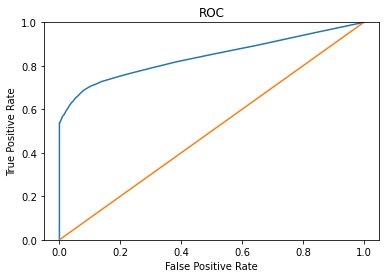

In [40]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt 

fpr, tpr, thresholds = roc_curve(test['class'], pred_prob)

plt.plot(fpr, tpr)
plt.plot([0,1], [0,1])
plt.ylim([0, 1.0])
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [41]:
# maximize the difference between true_positive and false_positive
# the same as maximize (1-clasee_1 error) - Class_0 error
# defined as class0_error = fpr and class1_error = 1 - tpr

error_cutoff=pd.DataFrame({'cutoff':pd.Series(thresholds),
                               'class0_error':pd.Series(fpr),
                               'class1_error': 1 - pd.Series(tpr)
                                })
error_cutoff['optimal_value'] = 1 - error_cutoff['class1_error'] - error_cutoff['class0_error']
print(error_cutoff.sort_values('optimal_value', ascending=False).head(1))


    cutoff  class0_error  class1_error  optimal_value
57    0.13      0.081241      0.311125       0.607634
